In [3]:
import pandas as pd
import numpy as np
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel


## 3: Text Representations
We will generate different text representations of the comments: TF-IDF, Word Embeddings and Transformers Encoding

### 3.1:TF-IDF
Term Frequency Inverse Document Frequency

In [4]:
df_ecoas = pd.read_csv('./datasets/df_scaled.csv', index_col=0)

In [5]:
aspects = ['APR', 'REC', 'RET', 'AVG']

In [6]:
df_ecoas.head()

,APR,DOM,EVA,MEJ,MET,PRA,REC,RET,ASE,GÉNERO ALUMNO,PROM ACUMULADO EN PROFESIONAL,Género del profesor,Tipo Comentario,Comentarios,AVG,Lemm
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,94.428,0.0,0,"Sabe explicar muy bien las cosas teoricas, pe...",0.0,"['saber', 'explicar', 'bien', 'cosa', 'teorico..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,95.968,0.0,0,Método anticuado de enseñar. Los temas podría...,0.0,"['método', 'anticuado', 'enseñar', 'tema', 'po..."
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,96.408,0.0,1,"Sabe muchísimo del tema, muy preparada.",0.0,"['saber', 'muchísimo', 'tema', 'preparado']"
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,94.981,0.0,2,buena maestra si lo recomiendo,1.0,"['buen', 'maestro', 'si', 'recomer']"
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,89.040,0.0,1,Tiene mucho conocimiento sobre los temas.,0.0,"['conocimiento', 'tema']"


In [7]:
from ast import literal_eval
df_ecoas['Lemm'] = df_ecoas['Lemm'].apply(literal_eval)

In [8]:
commentsL = df_ecoas['Lemm']

In [9]:
comments = df_ecoas['Comentarios']

for a in range(len(comments)):
  if type(comments[a]) is not str:
    print(type(comments[a]), 'No es str: ', a)
    df_ecoas.drop(index=a)

comments = comments.str.lower()

nltk.download('stopwords')
stop = stopwords.words('spanish')
stop.remove('no')
stop.append('es')

# Tokenize the comments
for i in range(len(comments)):
  comments[i] = str(comments[i]).split()
  comments[i] = [word for word in comments[i] if word not in stop]

# Remove the symbols and replace them with blank spaces
sim = "!\"#$%&()*+-.,/:;<=>?@[\]^_`{|}~\n"

# Para cada símbolo, se remplaza por blank space
for c in range(len(comments)):
  for i in range(len(comments[c])):
    for j in sim:
      if comments[c][i].__contains__(j):
        comments[c][i] = comments[c][i].replace(j,'')

comments

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoacosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        [sabe, explicar, bien, cosas, teoricas, hace, ...
1        [método, anticuado, enseñar, temas, podría, ha...
2                       [sabe, muchísimo, tema, preparada]
3                         [buena, maestra, si, recomiendo]
4                                    [conocimiento, temas]
                               ...                        
96535    [sabe, materia, gusta, enseñar, no, va, prisa,...
96536       [excelente, profesor, recomiendo, ampliamente]
96537    [profesor, llegó, salvar, semestre, pocas, cla...
96538    [dominio, tema, excelente, profesor, enseña, m...
96539    [triste, solo, pudo, dar, 3, clases, falto, ti...
Name: Comentarios, Length: 96540, dtype: object

In [10]:
# Merge comments
comentarios_merge=[None]*len(commentsL)
for i in range(len(commentsL)):
  comentarios_merge[i]=(TreebankWordDetokenizer().detokenize(list(commentsL[i])))

In [11]:
comentarios_merge[2]

'saber muchísimo tema preparado'

In [12]:
aspects_classes = df_ecoas[aspects]
aspects_classes.head()

,APR,REC,RET,AVG
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [13]:
comments_train,comments_test,aspects_train, aspects_test = train_test_split(comentarios_merge, aspects_classes, test_size=0.25, random_state=30)
print('Train:', 'Comentarios->', len(comments_train), 'Aspectos->',  aspects_train.shape, '\nTest:', 'Comentarios->', len(comments_test),'Aspectos->', aspects_test.shape)

Train: Comentarios-> 72405 Aspectos-> (72405, 4) 
Test: Comentarios-> 24135 Aspectos-> (24135, 4)


In [14]:
comments_train[:5]

['buen proyecto',
 'excelente profesor',
 'tomar clase ir recordar clase secundario lamentablemente manuel soto ser peor profesor año tec impartir curso peor manera posible semestre consistir presentación compañero cada tema curso profesor dar retroalimentación alguno comentario técnico interesante renunciar así todo responsabilidad enseñanza afortunadamente dado falta tema profesor impartir dos clase cual bajo calidad posible pues solo proyección vídeo breve parafraseo profesor suma evaluación consistir llenar espacio blanco textualmente mismo presentación enviar ejercicio bajo nivel resumen evidente falta interés profesor impartir materia potencial aprendizaje curso ser perdido culpa profesor no querer volver tomar clase profesor pues gustar formación académico calidad necesitar profesor universitario no secundario profesor manuel soto licón no merecer tec monterrey',
 'ademar conocimiento programa responder duda instante pregunta',
 'inteligente saber explicar bien dificultad']

In [15]:
vectorizer = TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(comments_train)
tf_x_test = vectorizer.transform(comments_test)

tf_idf = pd.DataFrame(tf_x_train.todense())
tf_idf.columns = vectorizer.get_feature_names_out()
tf_idf_matrix = tf_idf.T

tf_idf_matrix['Count'] = tf_idf_matrix.sum(axis=1)

# Top 15 words with the highest count
tf_idf_matrix = tf_idf_matrix.sort_values(by='Count', ascending=False).head(15)

print(tf_idf_matrix.drop(columns='Count').head(15))

                 0         1         2         3         4         5      \
buen          0.462317  0.000000  0.000000  0.000000  0.000000  0.000000   
clase         0.000000  0.000000  0.097404  0.000000  0.000000  0.000000   
no            0.000000  0.000000  0.085803  0.000000  0.000000  0.128508   
maestro       0.000000  0.000000  0.000000  0.000000  0.000000  0.152801   
explicar      0.000000  0.000000  0.000000  0.000000  0.267556  0.000000   
tema          0.000000  0.000000  0.060333  0.000000  0.000000  0.000000   
profesor      0.000000  0.669321  0.300372  0.000000  0.000000  0.000000   
excelente     0.000000  0.742973  0.000000  0.000000  0.000000  0.166459   
bien          0.000000  0.000000  0.000000  0.000000  0.286761  0.000000   
saber         0.000000  0.000000  0.000000  0.000000  0.291975  0.000000   
materia       0.000000  0.000000  0.034930  0.000000  0.000000  0.000000   
hacer         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
si          

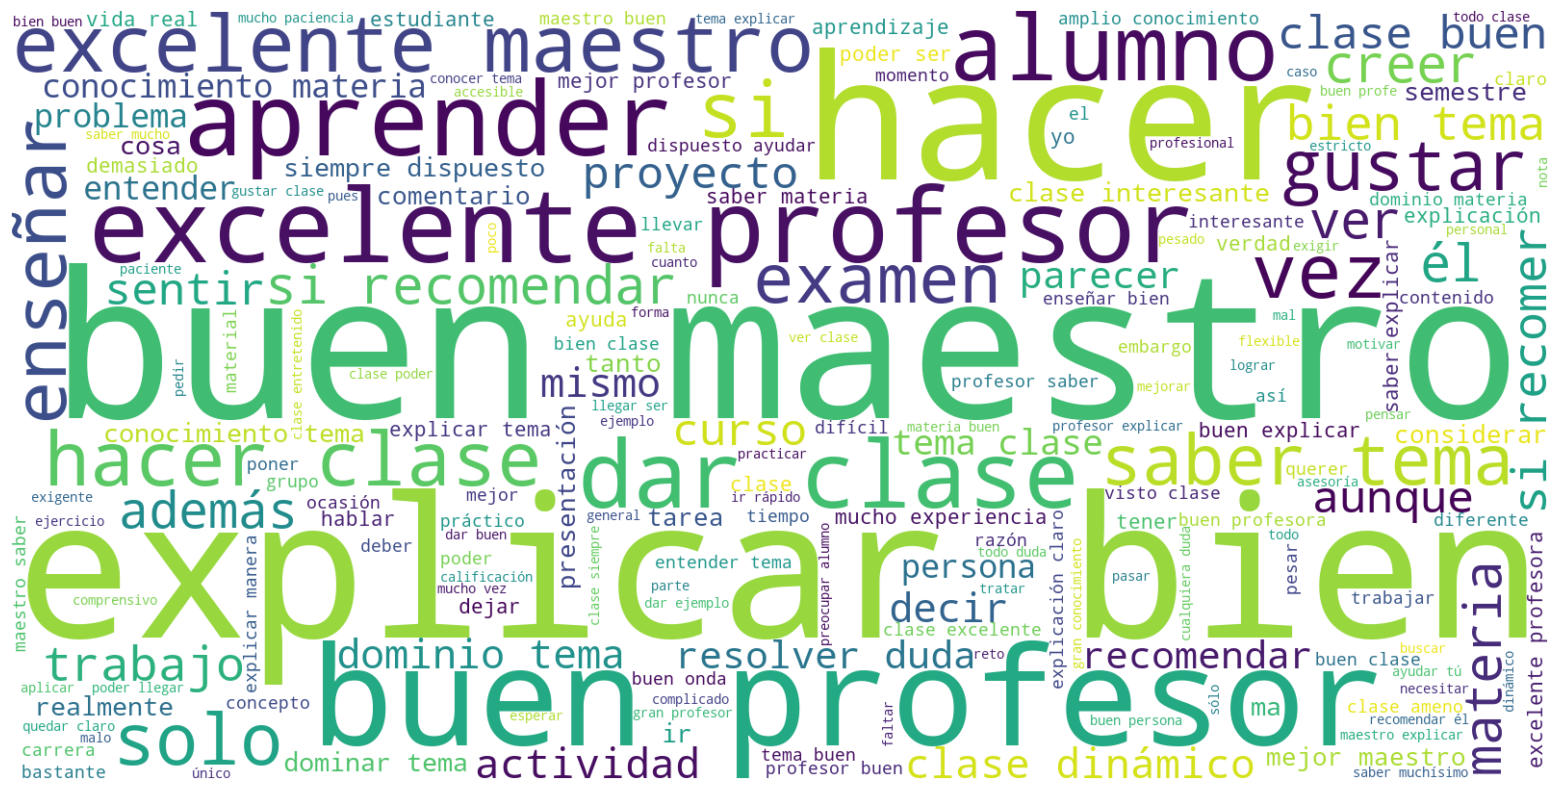

In [16]:
# Wordcloud
# Combine all the text data into a single string
text_data = ' '.join(comments_train)

# Create a WordCloud object
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text_data)

# collocations = False if you don't want to consider bigrams

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('./figures/WordCloud_TFIDF.png', dpi=300)
plt.show()

### 3.2:Word-Embeddings

In [17]:
nltk.download('stopwords')
stop = stopwords.words('spanish')
stop.remove('no')
stop.append('es')

# Train Word2Vec model on the comments
model = Word2Vec(sentences=commentsL, vector_size=100, window=5, min_count=1, workers=4)

# You can access the word vectors using the 'wv' attribute of the model
word_vectors = model.wv

# Get the vector representation of a word
vector = word_vectors['maestro']
# print(vector)
# Find similar words
similar_words = word_vectors.most_similar('maestro')
print(f'This are the most similar words to `maestro`: {similar_words}')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoacosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This are the most similar words to `maestro`: [('profesor', 0.8993081450462341), ('profesora', 0.8914458155632019), ('profe', 0.7242153882980347), ('miss', 0.6406822800636292), ('persona', 0.6122011542320251), ('doctora', 0.5936959981918335), ('actitud', 0.5223122835159302), ('característico', 0.49789953231811523), ('prof', 0.49548307061195374), ('doctor', 0.49353641271591187)]


In [18]:
# Other similar words
similar_words = word_vectors.most_similar('dominio')
print(f'This are the most similar words to `dominio`: {similar_words}')

similar_words = word_vectors.most_similar('actividad')
print(f'This are the most similar words to `actividad`: {similar_words}')

This are the most similar words to `dominio`: [('manejo', 0.7490339279174805), ('conocimiento', 0.7235881090164185), ('dominar', 0.6908732652664185), ('debrayar', 0.6874592900276184), ('experto', 0.6607964634895325), ('domino', 0.6341853737831116), ('conocedor', 0.6274660229682922), ('experta', 0.6225928664207458), ('entendimiento', 0.6004428863525391), ('experti', 0.5923922657966614)]
This are the most similar words to `actividad`: [('lectura', 0.7172344326972961), ('ejercicio', 0.7097815275192261), ('proyecto', 0.7082903385162354), ('laboratorio', 0.6622840762138367), ('disfrace', 0.6599013209342957), ('práctica', 0.6595298647880554), ('exposición', 0.6417891979217529), ('quizze', 0.624485194683075), ('tarea', 0.6233890056610107), ('trabajo', 0.6029691100120544)]


In [19]:
# Function to flatten the list of lists
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [20]:
# Aspects keywords # this one give me max similarity of 0.82 and min from those max of 0.15
MET_keywords = 'innovación tecnología herramientas explicaciones claridad precisión medios técnicas apoyo facilitación estilos ritmos aprendizaje recursos digitales aplicaciones interactivas plataformas educativas en línea dinámico participativo estrategias adaptación educación efectiva avanzadas enriquecimiento experiencia metodología actividades instructor estudiantes recursos digitales innovadoras tecnológicas estratégicas adaptativas participación'
PRA_keywords = 'casos proyectos problemas prácticas laboratorios talleres empresas organizaciones interacción profesionales teoría desafíos mundo real habilidades prácticas críticas resolución aplicación consolidación enfoque conocimiento preparación fomento desarrollo campo retos experiencia aprendizaje activo inmersión profundización comprensión contextualización aplicada realidad dinamismo pragmatismo soluciones'
ASE_keywords = 'interacción asesoría proceso éxito disponibilidad medios horarios ambiente respeto abierto apoyo dudas confianza profundo significativo potencial desarrollo profesor estudiantes entorno confianza motivación comprensión orientación consultas retroalimentación crecimiento diálogo comunicación empatía resolución preguntas accesibilidad dedicación involucramiento participación escucha asesoramiento'
EVA_keywords = 'evaluación retroalimentación fortalezas debilidades herramientas justa equitativa políticas criterios continua pruebas trabajos presentaciones orales progreso desarrollo mejora sistema integral métodos entendimiento contribución estudiante fomento calificación desempeño objetivos logros aprendizaje feedback autoevaluación peer-review competencias resultados análisis reflexión crecimiento mejora continua'
RET_keywords = 'reto intelectual estímulo interés motivación esfuerzo calidad aprendizaje crecimiento desafío tareas complejas significativas pensamiento crítico creatividad innovación conocimientos habilidades futuro profesional personal desarrollo solución problemas análisis reflexión autonomía perseverancia compromiso curiosidad exploración adquisición adaptabilidad resiliencia liderazgo colaboración ética'
APR_keywords = 'guía inspiración compromiso desarrollo crecimiento integral educador confianza pasión conocimiento entorno empoderamiento exploración cuestionamiento contribución proceso educativo centrado estudiante autonomía responsabilidad preparación desafíos futuros liderazgo ética colaboración innovación creatividad pensamiento crítico motivación perseverancia adaptabilidad resiliencia curiosidad explorador activo participativo'
DOM_keywords = 'dominio materia transmisión contenido educativo conocimientos experiencia campo claro interesante relevante conexiones conceptos curiosidad interés adaptación necesidades individuales enriquecimiento profundización experto profesional capacidad inspirador engagement contextualización aplicabilidad dinámica interactividad perspicacia visión comprensión analítica crítica metodológica didáctica pedagógica innovadora'

aspect_keywords = [MET_keywords, PRA_keywords, ASE_keywords, EVA_keywords, RET_keywords, APR_keywords, DOM_keywords]

# Tokenize the aspect keywords
for i in range(len(aspect_keywords)):
  aspect_keywords[i] = str(aspect_keywords[i]).split()
  aspect_keywords[i] = [word for word in aspect_keywords[i] if word not in stop]

print('Aspect keywords:', aspect_keywords)

Aspect keywords: [['innovación', 'tecnología', 'herramientas', 'explicaciones', 'claridad', 'precisión', 'medios', 'técnicas', 'apoyo', 'facilitación', 'estilos', 'ritmos', 'aprendizaje', 'recursos', 'digitales', 'aplicaciones', 'interactivas', 'plataformas', 'educativas', 'línea', 'dinámico', 'participativo', 'estrategias', 'adaptación', 'educación', 'efectiva', 'avanzadas', 'enriquecimiento', 'experiencia', 'metodología', 'actividades', 'instructor', 'estudiantes', 'recursos', 'digitales', 'innovadoras', 'tecnológicas', 'estratégicas', 'adaptativas', 'participación'], ['casos', 'proyectos', 'problemas', 'prácticas', 'laboratorios', 'talleres', 'empresas', 'organizaciones', 'interacción', 'profesionales', 'teoría', 'desafíos', 'mundo', 'real', 'habilidades', 'prácticas', 'críticas', 'resolución', 'aplicación', 'consolidación', 'enfoque', 'conocimiento', 'preparación', 'fomento', 'desarrollo', 'campo', 'retos', 'experiencia', 'aprendizaje', 'activo', 'inmersión', 'profundización', 'com

In [21]:
# Aspects general descriptions # this one give me max similarity of nan and min from those max of nan
MET = 'La metodología y actividades de aprendizaje son cruciales para una educación efectiva. Este aspecto abarca cómo el instructor brinda explicaciones claras y precisas, utilizando medios y técnicas innovadoras, junto con herramientas tecnológicas avanzadas. Estas estrategias facilitan y apoyan el aprendizaje del estudiante, adaptándose a diferentes estilos y ritmos de aprendizaje. La incorporación de recursos digitales, aplicaciones interactivas y plataformas educativas en línea enriquece la experiencia educativa, permitiendo un aprendizaje más dinámico y participativo'
PRA = 'La comprensión de conceptos a través de su aplicación práctica es fundamental para consolidar el aprendizaje. Este enfoque incluye la resolución de casos, proyectos o problemas reales, así como la realización de prácticas en laboratorios, talleres, visitas a empresas u organizaciones y la interacción con profesionales del campo. Estas actividades no solo enriquecen el conocimiento teórico sino que también preparan a los estudiantes para los desafíos del mundo real, fomentando el desarrollo de habilidades prácticas, críticas y de resolución de problemas'
ASE = 'La interacción efectiva con el profesor y la asesoría recibida son esenciales para un proceso de aprendizaje exitoso. Este aspecto destaca la disponibilidad del profesor en medios y horarios previamente acordados, proporcionando un ambiente de aprendizaje respetuoso y abierto. La capacidad del profesor para apoyar en la resolución de dudas y fomentar un entorno de confianza promueve un aprendizaje más profundo y significativo, permitiendo a los estudiantes desarrollar su potencial al máximo'
EVA = 'El sistema de evaluación juega un papel crucial en el proceso educativo, proporcionando retroalimentación valiosa sobre las fortalezas y debilidades del estudiante. Utilizando un conjunto diverso de herramientas, este sistema permite evaluar de manera justa y equitativa, basándose en políticas y criterios claramente establecidos. La evaluación continua, las pruebas, los trabajos de curso y las presentaciones orales son ejemplos de métodos que contribuyen a un entendimiento integral del progreso del estudiante, fomentando su desarrollo y mejora continua.'
RET = 'El nivel de reto intelectual es vital para estimular el interés y la motivación de los estudiantes, exigiéndoles dar su mayor esfuerzo y cumplir con calidad en beneficio de su aprendizaje y crecimiento personal. Este aspecto implica desafiar a los estudiantes con tareas complejas y significativas, promoviendo el pensamiento crítico, la creatividad y la innovación. Al enfrentarse a retos intelectuales, los estudiantes no solo adquieren conocimientos sino que también desarrollan habilidades esenciales para su futuro profesional y personal'
APR = 'El papel del educador como guía del aprendizaje es inspirar y demostrar compromiso con el aprendizaje, desarrollo y crecimiento integral de los estudiantes. A través de su ejemplo y dedicación, el profesor inspira confianza y pasión por el conocimiento, facilitando un entorno de aprendizaje en el que los estudiantes se sienten empoderados para explorar, cuestionar y contribuir activamente a su propio proceso educativo. Este enfoque centrado en el estudiante promueve la autonomía y la responsabilidad en el aprendizaje, preparándolos para enfrentar desafíos futuros con confianza'
DOM = 'El dominio de la materia por parte del profesor es un componente esencial para transmitir efectivamente el contenido educativo. Este aspecto refleja los profundos conocimientos y experiencia del educador en su campo, permitiéndole presentar los temas de manera clara, interesante y relevante. Un sólido dominio facilita la generación de conexiones entre conceptos, estimulando la curiosidad y el interés de los estudiantes. Además, habilita al profesor para adaptar su enseñanza a las necesidades individuales de los estudiantes, enriqueciendo su experiencia de aprendizaje.'

aspect_descriptions = [MET, PRA, ASE, EVA, RET, APR, DOM]

# Tokenize the aspect keywords
for i in range(len(aspect_descriptions)):
  aspect_descriptions[i] = str(aspect_descriptions[i]).split()
  aspect_descriptions[i] = [word for word in aspect_descriptions[i] if word not in stop]

print('Aspect general description:', aspect_descriptions)

Aspect general description: [['La', 'metodología', 'actividades', 'aprendizaje', 'cruciales', 'educación', 'efectiva.', 'Este', 'aspecto', 'abarca', 'cómo', 'instructor', 'brinda', 'explicaciones', 'claras', 'precisas,', 'utilizando', 'medios', 'técnicas', 'innovadoras,', 'junto', 'herramientas', 'tecnológicas', 'avanzadas.', 'Estas', 'estrategias', 'facilitan', 'apoyan', 'aprendizaje', 'estudiante,', 'adaptándose', 'diferentes', 'estilos', 'ritmos', 'aprendizaje.', 'La', 'incorporación', 'recursos', 'digitales,', 'aplicaciones', 'interactivas', 'plataformas', 'educativas', 'línea', 'enriquece', 'experiencia', 'educativa,', 'permitiendo', 'aprendizaje', 'dinámico', 'participativo'], ['La', 'comprensión', 'conceptos', 'través', 'aplicación', 'práctica', 'fundamental', 'consolidar', 'aprendizaje.', 'Este', 'enfoque', 'incluye', 'resolución', 'casos,', 'proyectos', 'problemas', 'reales,', 'así', 'realización', 'prácticas', 'laboratorios,', 'talleres,', 'visitas', 'empresas', 'u', 'organiz

In [22]:
# Aspects descriptions for the students point of view
MET_student = 'Como estudiante, valoro cuando los profesores utilizan metodologías y actividades de aprendizaje que me brindan explicaciones claras y precisas. Aprecio especialmente el uso de medios y técnicas innovadoras, como herramientas tecnológicas, que hacen el aprendizaje más accesible y atractivo. Estas estrategias no solo facilitan mi comprensión de los temas, sino que también estimulan mi curiosidad y deseo de explorar más allá de lo básico, apoyando eficazmente mi proceso educativo'
PRA_student = 'La posibilidad de aplicar en la práctica lo que aprendo en teoría es fundamental para mí. A través de la resolución de casos reales, proyectos, y prácticas en laboratorios o talleres, siento que mi educación cobra sentido. Visitar empresas y organizaciones o interactuar con profesionales que aplican los temas discutidos en clase me ayuda a comprender mejor cómo se utilizan estos conceptos en el mundo real, preparándome para mi futuro profesional'
ASE_student = 'La interacción con mi profesor y la asesoría que recibo son clave para mi aprendizaje. Cuando un profesor está disponible para resolver mis dudas, ya sea en horarios convenidos o a través de medios digitales, me siento más apoyado y confiado en mi proceso educativo. Un ambiente de aprendizaje respetuoso y abierto, donde puedo expresar mis opiniones y preguntas sin temor, es esencial para mi desarrollo académico y personal'
EVA_student = 'El sistema de evaluación me ayuda a entender mis fortalezas y debilidades dentro del curso. Aprecio cuando se utilizan diversas herramientas de evaluación que ofrecen retroalimentación constructiva, basadas en criterios claros y justos. Esta retroalimentación me permite identificar áreas de mejora y reconocer mis logros, guiándome hacia un aprendizaje más efectivo y personalizado'
RET_student = 'Me siento genuinamente motivado cuando los desafíos intelectuales me exigen dar lo mejor de mí. Los retos que me llevan a cuestionar lo que sé y a esforzarme por entender y aplicar conceptos complejos enriquecen mi experiencia educativa. Este nivel de exigencia no solo impulsa mi crecimiento académico, sino que también fomenta mi desarrollo personal, preparándome para enfrentar futuros desafíos con confianza.'
APR_student = 'Cuando un profesor actúa como guía en mi aprendizaje, inspirándome y demostrando un compromiso genuino con mi desarrollo, siento que mi educación se personaliza y profundiza. Esta actitud no solo me motiva a aprender más, sino que también me enseña la importancia del compromiso y la pasión por el conocimiento. Un educador que guía, desafía e inspira es fundamental para mi crecimiento integral como estudiante'
DOM_student = 'El dominio de la materia por parte de mi profesor es imprescindible. Cuando un educador tiene un profundo conocimiento y experiencia en el tema que enseña, las clases son más claras, interesantes y relevantes. Este dominio permite al profesor conectar los conceptos con la vida real, despertando mi curiosidad y fomentando un aprendizaje más significativo. Además, un profesor que realmente entiende su materia puede adaptar la enseñanza a las necesidades de sus estudiantes, enriqueciendo nuestra experiencia educativa.'

aspects_studentpov = [MET_student, PRA_student, ASE_student, EVA_student, RET_student, APR_student, DOM_student]

# Tokenize the aspect keywords
for i in range(len(aspects_studentpov)):
  aspects_studentpov[i] = str(aspects_studentpov[i]).split()
  aspects_studentpov[i] = [word for word in aspects_studentpov[i] if word not in stop]

print('Aspect descriptions as student POV:', aspects_studentpov)

Aspect descriptions as student POV: [['Como', 'estudiante,', 'valoro', 'profesores', 'utilizan', 'metodologías', 'actividades', 'aprendizaje', 'brindan', 'explicaciones', 'claras', 'precisas.', 'Aprecio', 'especialmente', 'uso', 'medios', 'técnicas', 'innovadoras,', 'herramientas', 'tecnológicas,', 'hacen', 'aprendizaje', 'accesible', 'atractivo.', 'Estas', 'estrategias', 'no', 'solo', 'facilitan', 'comprensión', 'temas,', 'sino', 'estimulan', 'curiosidad', 'deseo', 'explorar', 'allá', 'básico,', 'apoyando', 'eficazmente', 'proceso', 'educativo'], ['La', 'posibilidad', 'aplicar', 'práctica', 'aprendo', 'teoría', 'fundamental', 'mí.', 'A', 'través', 'resolución', 'casos', 'reales,', 'proyectos,', 'prácticas', 'laboratorios', 'talleres,', 'siento', 'educación', 'cobra', 'sentido.', 'Visitar', 'empresas', 'organizaciones', 'interactuar', 'profesionales', 'aplican', 'temas', 'discutidos', 'clase', 'ayuda', 'comprender', 'mejor', 'cómo', 'utilizan', 'conceptos', 'mundo', 'real,', 'preparánd

In [23]:
# Aspects exact questions in the SET
ecoa_questions = [
# MET
'metodología y actividades de aprendizaje (me brindó explicaciones claras y precisas, medios y técnicas innovadoras o herramientas tecnológicas que facilitaron y apoyaron mi aprendizaje)',
# PRA
'comprensión de conceptos en términos de su aplicación en la práctica (resolví casos, proyectos o problemas reales, realicé prácticas en laboratorios o talleres, visitas a empresas u organizaciones, o interactué con personas que trabajan aplicando los temas de la clase)',
# ASE
'interacción con el profesor y la asesoría recibida durante el proceso de aprendizaje (me apoyó para resolver dudas, el profesor estuvo disponible en medios y horarios previamente acordados, hubo un ambiente de aprendizaje respetuoso y abierto)',
# EVA
'sistema de evaluación (se utilizó un conjunto de herramientas que me dieron retroalimentación sobre mis fortalezas y debilidades en el curso con base en políticas y criterios establecidos oportunamente)',
# RET
'nivel de reto intelectual (me motivó y me exigió dar mi mayor esfuerzo y cumplir con calidad en beneficio de mi aprendizaje y mi crecimiento personal)',
# APR
'papel como guía del aprendizaje (me inspiró y demostró compromiso con mi aprendizaje, desarrollo y crecimiento integral)',
# DOM
'dominio de la materia (sus conocimientos y experiencia)',
]

# Tokenize the aspect keywords
for i in range(len(ecoa_questions)):
  ecoa_questions[i] = str(ecoa_questions[i]).split()
  ecoa_questions[i] = [word for word in ecoa_questions[i] if word not in stop]


print('Aspect ecoa questions:', ecoa_questions)

Aspect ecoa questions: [['metodología', 'actividades', 'aprendizaje', '(me', 'brindó', 'explicaciones', 'claras', 'precisas,', 'medios', 'técnicas', 'innovadoras', 'herramientas', 'tecnológicas', 'facilitaron', 'apoyaron', 'aprendizaje)'], ['comprensión', 'conceptos', 'términos', 'aplicación', 'práctica', '(resolví', 'casos,', 'proyectos', 'problemas', 'reales,', 'realicé', 'prácticas', 'laboratorios', 'talleres,', 'visitas', 'empresas', 'u', 'organizaciones,', 'interactué', 'personas', 'trabajan', 'aplicando', 'temas', 'clase)'], ['interacción', 'profesor', 'asesoría', 'recibida', 'proceso', 'aprendizaje', '(me', 'apoyó', 'resolver', 'dudas,', 'profesor', 'disponible', 'medios', 'horarios', 'previamente', 'acordados,', 'ambiente', 'aprendizaje', 'respetuoso', 'abierto)'], ['sistema', 'evaluación', '(se', 'utilizó', 'conjunto', 'herramientas', 'dieron', 'retroalimentación', 'fortalezas', 'debilidades', 'curso', 'base', 'políticas', 'criterios', 'establecidos', 'oportunamente)'], ['nive

In [24]:
# We can now create a vector using the word vectors from the Word2Vec model

def get_embedding(descriptions): # Function to obtain the description vector
    asp_emb = []
    for description in descriptions:
        description_words = description  # Split the comment into individual words
        description_vector = np.zeros(model.vector_size)  # Initialize an array of zeros for the comment vector
        
        for word in description_words:
            if word in model.wv:
                description_vector += model.wv[word]  # Add the word vector to the comment vector
        asp_emb.append(description_vector)
    return asp_emb


In [25]:
aspects = ['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM', 'REC', 'MEJ']

In [26]:
# Example usage for the aspect keywords
aspects_keywords_vectors = get_embedding(aspect_keywords)

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(aspects_keywords_vectors[0])

print(f"The most similar words to the aspect {aspects[0]}: '{aspect_keywords[0]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

The most similar words to the aspect MET: '['innovación', 'tecnología', 'herramientas', 'explicaciones', 'claridad', 'precisión', 'medios', 'técnicas', 'apoyo', 'facilitación', 'estilos', 'ritmos', 'aprendizaje', 'recursos', 'digitales', 'aplicaciones', 'interactivas', 'plataformas', 'educativas', 'línea', 'dinámico', 'participativo', 'estrategias', 'adaptación', 'educación', 'efectiva', 'avanzadas', 'enriquecimiento', 'experiencia', 'metodología', 'actividades', 'instructor', 'estudiantes', 'recursos', 'digitales', 'innovadoras', 'tecnológicas', 'estratégicas', 'adaptativas', 'participación']' are:
enseñado: 0.7597881555557251
simulación: 0.7592905163764954
actualización: 0.7506295442581177
diverso: 0.7464578151702881
óptimo: 0.7434507012367249
competencia: 0.7418310642242432
meramente: 0.7411834597587585
pedagógico: 0.740266740322113
aporte: 0.7378959059715271
audiovisual: 0.7371801733970642


In [27]:
# Example usage for the aspect descriptions
aspects_description_vectors = get_embedding(aspect_descriptions)

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(aspects_description_vectors[1])

print(f"The most similar words to the aspect {aspects[1]}: '{aspect_descriptions[1]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

The most similar words to the aspect PRA: '['La', 'comprensión', 'conceptos', 'través', 'aplicación', 'práctica', 'fundamental', 'consolidar', 'aprendizaje.', 'Este', 'enfoque', 'incluye', 'resolución', 'casos,', 'proyectos', 'problemas', 'reales,', 'así', 'realización', 'prácticas', 'laboratorios,', 'talleres,', 'visitas', 'empresas', 'u', 'organizaciones', 'interacción', 'profesionales', 'campo.', 'Estas', 'actividades', 'no', 'solo', 'enriquecen', 'conocimiento', 'teórico', 'sino', 'preparan', 'estudiantes', 'desafíos', 'mundo', 'real,', 'fomentando', 'desarrollo', 'habilidades', 'prácticas,', 'críticas', 'resolución', 'problemas']' are:
través: 0.8359510898590088
aprendido: 0.8090765476226807
aplicación: 0.7995650172233582
análisis: 0.7876031994819641
práctico: 0.7813723683357239
posteriormente: 0.7749046087265015
función: 0.7660746574401855
uso: 0.7602624297142029
escalar: 0.7593223452568054
fundamento: 0.7527118921279907


In [28]:
# Example usage for the aspect descriptions from student POV
aspects_studentpov_vectors = get_embedding(aspects_studentpov)

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(aspects_studentpov_vectors[2])

print(f"The most similar words to the aspect {aspects[2]}: '{aspects_studentpov[2]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

The most similar words to the aspect ASE: '['La', 'interacción', 'profesor', 'asesoría', 'recibo', 'clave', 'aprendizaje.', 'Cuando', 'profesor', 'disponible', 'resolver', 'dudas,', 'horarios', 'convenidos', 'través', 'medios', 'digitales,', 'siento', 'apoyado', 'confiado', 'proceso', 'educativo.', 'Un', 'ambiente', 'aprendizaje', 'respetuoso', 'abierto,', 'puedo', 'expresar', 'opiniones', 'preguntas', 'temor,', 'esencial', 'desarrollo', 'académico', 'personal']' are:
acompañar: 0.726251482963562
guiar: 0.7186896204948425
presente: 0.7135661840438843
progreso: 0.6962687373161316
beneficio: 0.6933863162994385
preocupación: 0.6851726770401001
contribuir: 0.6846332550048828
neceitar: 0.6808770298957825
participante: 0.6805898547172546
aula: 0.6785585284233093


In [29]:
# Example usage for the aspect descriptions from the exact question in the SET
aspects_questions_vectors = get_embedding(ecoa_questions)

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(aspects_questions_vectors[4])

print(f"The most similar words to the aspect {aspects[4]}: '{ecoa_questions[4]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

The most similar words to the aspect RET: '['nivel', 'reto', 'intelectual', '(me', 'motivó', 'exigió', 'dar', 'mayor', 'esfuerzo', 'cumplir', 'calidad', 'beneficio', 'aprendizaje', 'crecimiento', 'personal)']' are:
representar: 0.7660399079322815
disminuir: 0.7584721446037292
mayor: 0.7568089962005615
exigencia: 0.7512997984886169
intelectual: 0.7480581998825073
esfuerzo: 0.7467313408851624
considerablemente: 0.7419565320014954
complejidad: 0.7336457967758179
competencia: 0.7233046889305115
desempeño: 0.7219197750091553


#### PCA: Principal Component Analysis

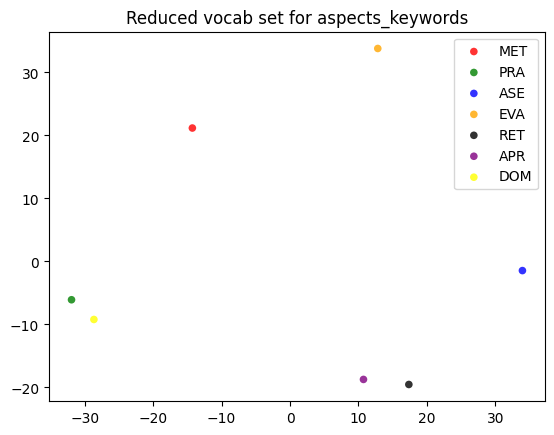

In [30]:
# We can use PCA to reduce the number of dimensions of the vectors
pca = PCA(n_components=2)
# Perform PCA
pca_embeddings = pca.fit_transform(aspects_keywords_vectors)
def two_d_graph(pca_embeddings, title):
    colors = ("red", "green", "blue", "orange", "black", "purple", "yellow")
 
    # Create plot
    fig = plt.figure()
    ax = fig.gca()
 
    for data, color, group in zip(pca_embeddings, colors, aspects[:7]):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
 
    plt.title(title)
    plt.legend(loc=1)
    plt.show()

two_d_graph(pca_embeddings, 'Reduced vocab set for aspects_keywords')

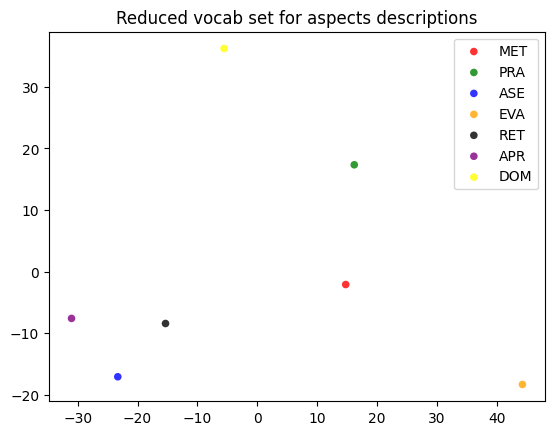

In [31]:
# We will do the same for the aspect descriptions
pca = PCA(n_components=2)
# Perform PCA
pca_embeddings = pca.fit_transform(aspects_description_vectors)
two_d_graph(pca_embeddings, 'Reduced vocab set for aspects descriptions')

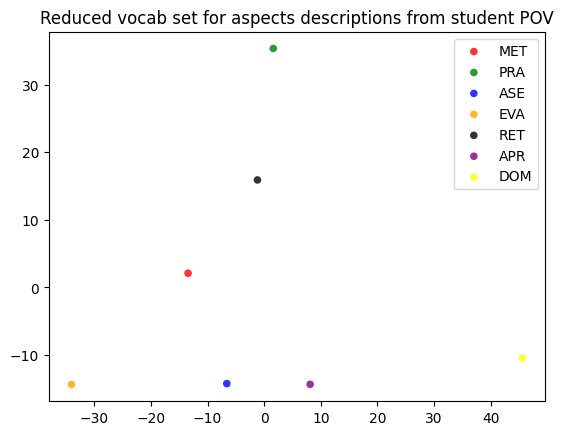

In [32]:
# We will do the same for the aspect students POV descriptions
pca = PCA(n_components=2)
# Perform PCA
pca_embeddings = pca.fit_transform(aspects_studentpov_vectors)
two_d_graph(pca_embeddings, 'Reduced vocab set for aspects descriptions from student POV')

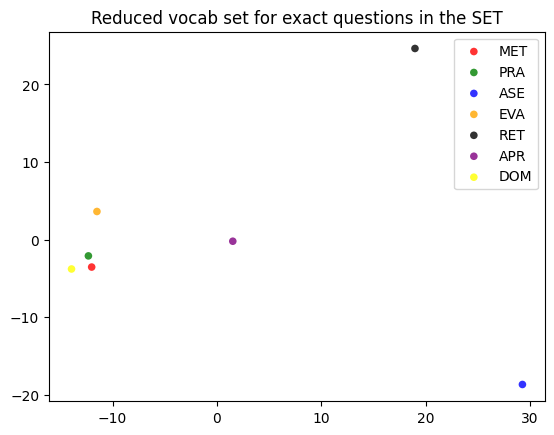

In [33]:
# Finally, we do the same for the aspect exact questions in the SET
pca = PCA(n_components=2)
# Perform PCA
pca_embeddings = pca.fit_transform(aspects_questions_vectors)
two_d_graph(pca_embeddings, 'Reduced vocab set for exact questions in the SET')

#### t-SNE

In [34]:
# We don't want to use all the aspects because REC y MEJ are not in the Word2Vec model, so we will use only the first 7 aspects
aspects[:7]

['MET', 'PRA', 'ASE', 'EVA', 'RET', 'APR', 'DOM']

In [35]:
np.array(aspects_keywords_vectors).shape

(7, 100)

In [36]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(np.array(aspects_keywords_vectors).T)

In [37]:
pca_embeddings

array([[-12.00464615,  -3.53035386],
       [-12.31792104,  -2.09109461],
       [ 29.26816701, -18.65604422],
       [-11.49891214,   3.62877538],
       [ 18.97290244,  24.62845352],
       [  1.51616767,  -0.20174095],
       [-13.93575779,  -3.77799528]])

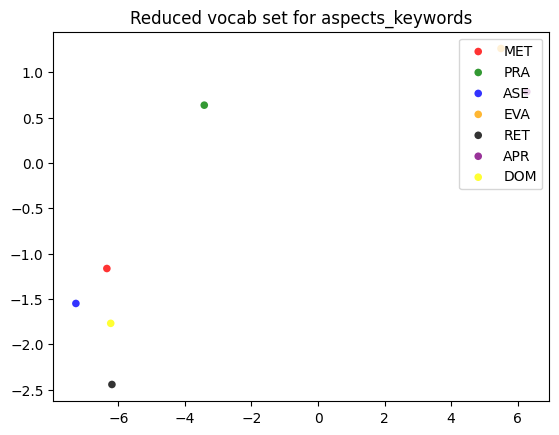

In [38]:
def two_d_graph(pca_embeddings, title):
    colors = ("red", "green", "blue", "orange", "black", "purple", "yellow")
 
    # Create plot
    fig = plt.figure()
    ax = fig.gca()
 
    for data, color, group in zip(pca_embeddings, colors, aspects[:7]):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
 
    plt.title(title)
    plt.legend(loc=1)
    plt.show()

two_d_graph(X_tsne, 'Reduced vocab set for aspects_keywords')

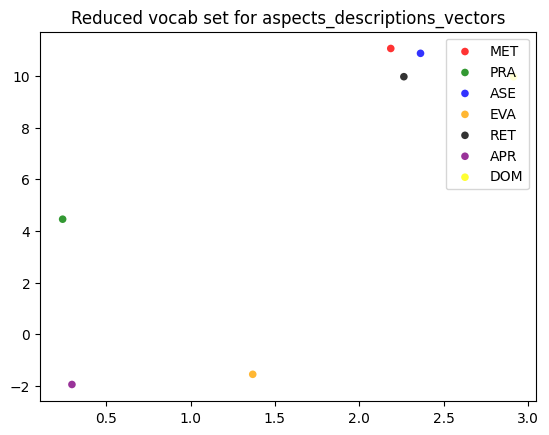

In [39]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(np.array(aspects_description_vectors).T)
two_d_graph(X_tsne, 'Reduced vocab set for aspects_descriptions_vectors')

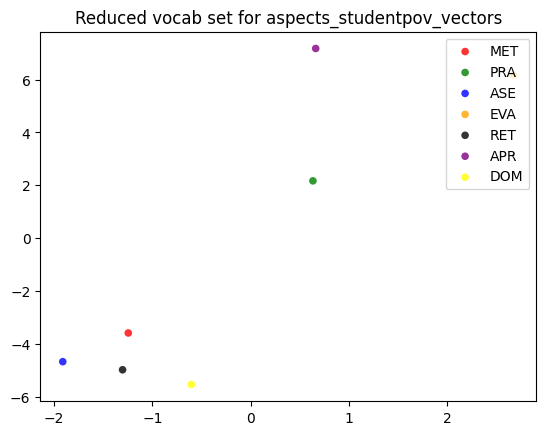

In [40]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(np.array(aspects_studentpov_vectors).T)
two_d_graph(X_tsne, 'Reduced vocab set for aspects_studentpov_vectors')

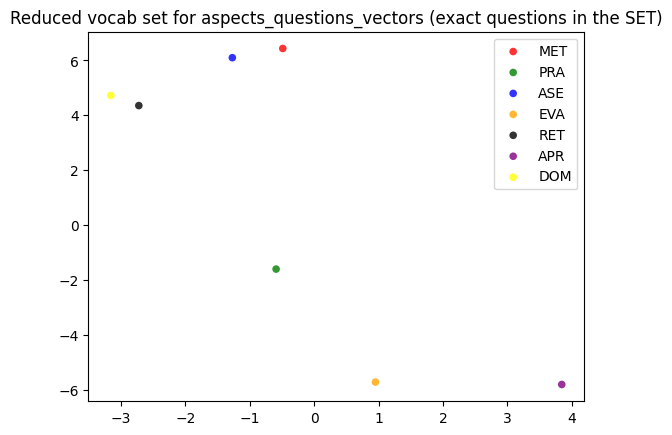

In [41]:
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(np.array(aspects_questions_vectors).T)
two_d_graph(X_tsne, 'Reduced vocab set for aspects_questions_vectors (exact questions in the SET)')

#### Saving the word embeddings model

In [42]:
# We can now create a comment vector using the word vectors from the Word2Vec model and obtain the most similar words

# Define a function to obtain the comment vector
def get_comment_vector(comment):
    comment_words = comment  # Split the comment into individual words
    comment_vector = np.zeros(model.vector_size)  # Initialize an array of zeros for the comment vector
    
    for word in comment_words:
        if word in model.wv:
            comment_vector += model.wv[word]  # Add the word vector to the comment vector
    
    return comment_vector

# Example usage
comment_vector = get_comment_vector(commentsL[2])

# Obtain the most similar words to the comment
similar_words = model.wv.similar_by_vector(comment_vector)

print(f"The most similar words to the comment '{commentsL[2]}' are:")
for word, similarity in similar_words:
    print(f"{word}: {similarity}")


The most similar words to the comment '['saber', 'muchísimo', 'tema', 'preparado']' are:
acerca: 0.7061273455619812
saber: 0.7015336751937866
muchísimo: 0.6568263173103333
apasionar: 0.6494138240814209
tema: 0.6322560906410217
muchisimo: 0.6134927272796631
fondo: 0.6112040877342224
perfectamente: 0.6092137694358826
aparte: 0.6042436957359314
preparado: 0.5646139979362488


In [43]:
# Save the model
model.save('./w2v_models/word2vec.model')

In [44]:
# Load the model
model = Word2Vec.load('./w2v_models/word2vec.model')

## 4:Topic Recognizion

Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation (LDA) is a type of statistical model that is used to discover the abstract "topics" that occur in a collection of documents. It's widely used in natural language processing (NLP) for tasks like document classification, organizing large sets of documents, and helping in understanding the main themes (educational aspects in this case) in them.

In [45]:
# Create dictionary and document-term matrix
dictionary = corpora.Dictionary(commentsL)
corpus = [dictionary.doc2bow(doc) for doc in commentsL]

In [46]:
# Build LDA model
num_topics = 8
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print topics and their top keywords
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

# Get topics for each document
topics_for_documents = [lda_model[doc] for doc in corpus]

Topic: 0 
Words: 0.152*"no" + 0.026*"saber" + 0.024*"examen" + 0.020*"si" + 0.020*"vez" + 0.019*"hacer" + 0.018*"ir" + 0.016*"cosa" + 0.015*"tarea" + 0.013*"decir"

Topic: 1 
Words: 0.300*"buen" + 0.126*"maestro" + 0.064*"profesor" + 0.063*"si" + 0.043*"recomendar" + 0.042*"excelente" + 0.038*"recomer" + 0.023*"preocupar" + 0.020*"alumno" + 0.015*"profe"

Topic: 2 
Words: 0.034*"clase" + 0.032*"tema" + 0.022*"dar" + 0.016*"ejemplo" + 0.016*"proyecto" + 0.016*"vida" + 0.015*"real" + 0.012*"caso" + 0.011*"claro" + 0.011*"práctico"

Topic: 3 
Words: 0.132*"clase" + 0.057*"hacer" + 0.045*"aprender" + 0.031*"mejor" + 0.024*"dinámico" + 0.021*"maestro" + 0.021*"dar" + 0.020*"siempre" + 0.016*"interesante" + 0.016*"alumno"

Topic: 4 
Words: 0.148*"saber" + 0.131*"tema" + 0.087*"clase" + 0.076*"materia" + 0.039*"dominar" + 0.035*"conocer" + 0.027*"interesante" + 0.022*"demasiado" + 0.021*"hacer" + 0.015*"hablar"

Topic: 5 
Words: 0.084*"no" + 0.063*"clase" + 0.028*"poder" + 0.024*"ser" + 0.023

In [47]:
# Define the number of topics
num_topics = 8

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(commentsL)

# Filter out tokens that appear in less than 10 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Convert the documents into a bag-of-words format: list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(doc) for doc in commentsL]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Print the top keywords for each topic
for topic_id in range(num_topics):
    top_words = lda_model.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word[0] for word in top_words])

# Compute coherence score to evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=commentsL, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)

topics_for_documents = [lda_model[doc] for doc in corpus]

Topic 1:
['explicar', 'bien', 'explicación', 'demasiado', 'fácil', 'volver', 'enseñanza', 'información', 'importante', 'evaluar']
Topic 2:
['persona', 'semestre', 'comprender', 'ayuda', 'aburrido', 'mismo', 'grupo', 'atención', 'considerar', 'diferente']
Topic 3:
['tema', 'buen', 'saber', 'maestro', 'alumno', 'si', 'él', 'enseñar', 'recomendar', 'entender']
Topic 4:
['interesante', 'concepto', 'llevar', 'decir', 'tedioso', 'práctico', 'actitud', 'final', 'el', 'perder']
Topic 5:
['siempre', 'mejor', 'ayudar', 'todo', 'dominar', 'parecer', 'hora', 'tú', 'buscar', 'dispuesto']
Topic 6:
['profesor', 'excelente', 'aprender', 'nunca', 'interesar', 'difícil', 'evaluación', 'mal', 'divertido', 'trabajar']
Topic 7:
['materia', 'conocimiento', 'ser', 'experiencia', 'gran', 'cada', 'embargo', 'necesitar', 'calificación', 'calificar']
Topic 8:
['clase', 'no', 'hacer', 'dar', 'mucho', 'poder', 'vez', 'manera', 'duda', 'ver']

Coherence Score: 0.5396679415051697


In [48]:
len(topics_for_documents)

96540

In [49]:
commentsL[2]

['saber', 'muchísimo', 'tema', 'preparado']

In [50]:
topics_for_documents[0]

([(0, 0.08475492),
  (1, 0.03248213),
  (2, 0.16973849),
  (3, 0.06106166),
  (4, 0.040244337),
  (5, 0.03985995),
  (6, 0.06058521),
  (7, 0.5112734)],
 [(0, [3]),
  (1, [7]),
  (2, [7]),
  (3, [0]),
  (4, [0]),
  (5, [7]),
  (6, [7]),
  (7, [7]),
  (8, [7]),
  (9, [7]),
  (10, [0]),
  (11, [7]),
  (12, [7]),
  (13, [7]),
  (14, [3, 6, 7, 1, 4, 2]),
  (15, [7]),
  (16, [7]),
  (17, [7]),
  (18, [7]),
  (19, [7]),
  (20, [7]),
  (21, [2]),
  (22, [7]),
  (23, [2]),
  (24, [7]),
  (25, [7]),
  (26, [7])],
 [(0, [(3, 0.99620944)]),
  (1, [(7, 0.9999128)]),
  (2, [(7, 0.9996233)]),
  (3, [(0, 0.9986586)]),
  (4, [(0, 0.9999922)]),
  (5, [(7, 0.99973106)]),
  (6, [(7, 0.99997973)]),
  (7, [(7, 0.99999297)]),
  (8, [(7, 0.99997276)]),
  (9, [(7, 0.99980503)]),
  (10, [(0, 0.9999938)]),
  (11, [(7, 0.99997497)]),
  (12, [(7, 0.9999943)]),
  (13, [(7, 0.99929404)]),
  (14,
   [(1, 0.09134803),
    (2, 0.018702624),
    (3, 0.8386599),
    (4, 0.025585024),
    (6, 0.78517306),
    (7, 0.11093

LDA hyper-parameters fine tuning:

Use different number of values of filter extremes and observe the performance on coherence score for different number of topics

In [51]:
# Define a range of no_below filter extreme values
below1 = 100
below2 = 1000
below3 = 2500
below4 = 0

#Define a range of no_above filter extreme values
above1 = 0.7
above2 = 0.65
above3 = 0.6
above4 = 1

extreme_values = [[below1, above1],[below2, above2],[below3, above3], [below4, above4]]

# Define a range of candidate numbers of topics
min_topics = 2
max_topics = 10
step_size = 1
topic_range = range(min_topics, max_topics + 1, step_size)

In [52]:
dictionary = corpora.Dictionary(commentsL)
print(len(dictionary))

17837


In [53]:
for extremes in extreme_values:
    print('- - - - - - - - - - - - - - - - - - - - - - - ')
    coherence_scores = []
    for num_topics in topic_range:
        print(f'Number of topics: {num_topics} Extremes: {extremes}')
        # Create a dictionary representation of the documents.
        dictionary = corpora.Dictionary(commentsL)

        # Filter out tokens that appear in less than 10 documents or more than 50% of the documents
        dictionary.filter_extremes(no_below=extremes[0], no_above=extremes[1])
        dictionary.compactify()
        print(len(dictionary))

        # Convert the documents into a bag-of-words format: list of (token_id, token_count) tuples
        corpus = [dictionary.doc2bow(doc) for doc in commentsL]

- - - - - - - - - - - - - - - - - - - - - - - 
Number of topics: 2 Extremes: [100, 0.7]
887
Number of topics: 3 Extremes: [100, 0.7]
887
Number of topics: 4 Extremes: [100, 0.7]
887
Number of topics: 5 Extremes: [100, 0.7]
887
Number of topics: 6 Extremes: [100, 0.7]
887
Number of topics: 7 Extremes: [100, 0.7]
887
Number of topics: 8 Extremes: [100, 0.7]
887
Number of topics: 9 Extremes: [100, 0.7]
887
Number of topics: 10 Extremes: [100, 0.7]
887
- - - - - - - - - - - - - - - - - - - - - - - 
Number of topics: 2 Extremes: [1000, 0.65]
172
Number of topics: 3 Extremes: [1000, 0.65]
172
Number of topics: 4 Extremes: [1000, 0.65]
172
Number of topics: 5 Extremes: [1000, 0.65]
172
Number of topics: 6 Extremes: [1000, 0.65]
172
Number of topics: 7 Extremes: [1000, 0.65]
172
Number of topics: 8 Extremes: [1000, 0.65]
172
Number of topics: 9 Extremes: [1000, 0.65]
172
Number of topics: 10 Extremes: [1000, 0.65]
172
- - - - - - - - - - - - - - - - - - - - - - - 
Number of topics: 2 Extremes:

- - - - - - - - - - - - - - - - - - - - - - - 
Len of the Dictionary: 887
Number of topics: 2 Extremes: [100, 0.7]
Number of topics: 3 Extremes: [100, 0.7]
Number of topics: 4 Extremes: [100, 0.7]
Number of topics: 5 Extremes: [100, 0.7]
Number of topics: 6 Extremes: [100, 0.7]
Number of topics: 7 Extremes: [100, 0.7]
Number of topics: 8 Extremes: [100, 0.7]
Number of topics: 9 Extremes: [100, 0.7]
Number of topics: 10 Extremes: [100, 0.7]


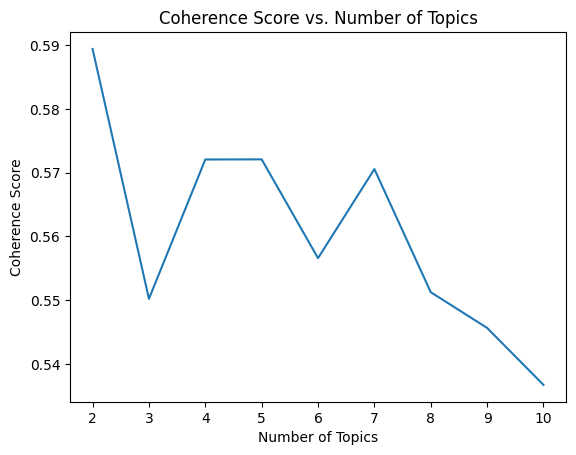

- - - - - - - - - - - - - - - - - - - - - - - 
Len of the Dictionary: 172
Number of topics: 2 Extremes: [1000, 0.65]
Number of topics: 3 Extremes: [1000, 0.65]
Number of topics: 4 Extremes: [1000, 0.65]
Number of topics: 5 Extremes: [1000, 0.65]
Number of topics: 6 Extremes: [1000, 0.65]
Number of topics: 7 Extremes: [1000, 0.65]
Number of topics: 8 Extremes: [1000, 0.65]
Number of topics: 9 Extremes: [1000, 0.65]
Number of topics: 10 Extremes: [1000, 0.65]


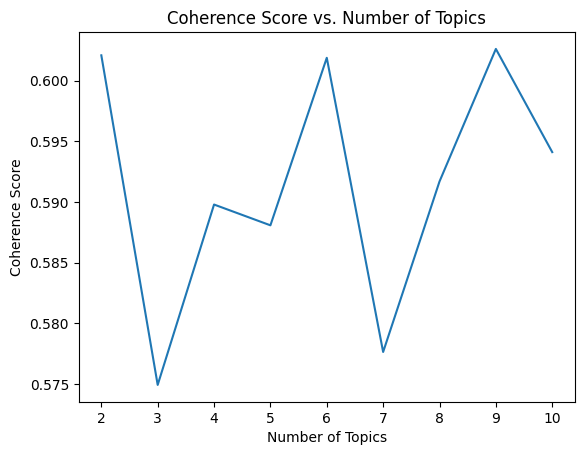

- - - - - - - - - - - - - - - - - - - - - - - 
Len of the Dictionary: 63
Number of topics: 2 Extremes: [2500, 0.6]
Number of topics: 3 Extremes: [2500, 0.6]
Number of topics: 4 Extremes: [2500, 0.6]
Number of topics: 5 Extremes: [2500, 0.6]
Number of topics: 6 Extremes: [2500, 0.6]
Number of topics: 7 Extremes: [2500, 0.6]
Number of topics: 8 Extremes: [2500, 0.6]
Number of topics: 9 Extremes: [2500, 0.6]
Number of topics: 10 Extremes: [2500, 0.6]


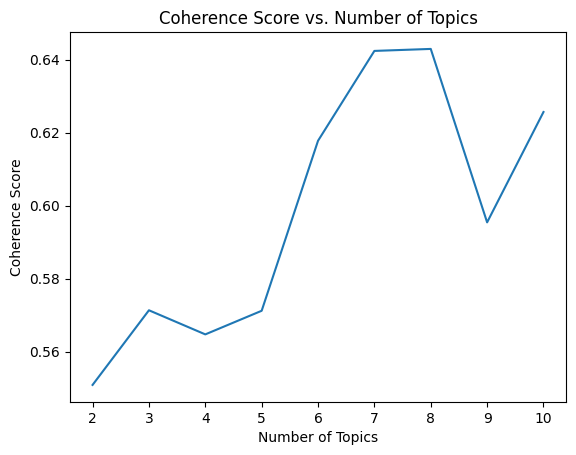

- - - - - - - - - - - - - - - - - - - - - - - 
Len of the Dictionary: 17837
Number of topics: 2 Extremes: [0, 1]
Number of topics: 3 Extremes: [0, 1]
Number of topics: 4 Extremes: [0, 1]
Number of topics: 5 Extremes: [0, 1]
Number of topics: 6 Extremes: [0, 1]
Number of topics: 7 Extremes: [0, 1]
Number of topics: 8 Extremes: [0, 1]
Number of topics: 9 Extremes: [0, 1]
Number of topics: 10 Extremes: [0, 1]


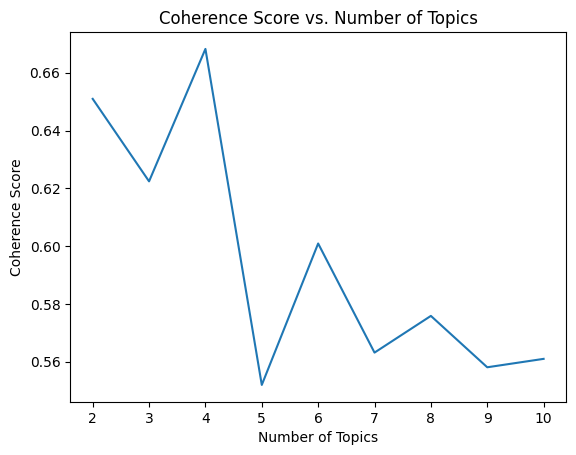

In [54]:
for extremes in extreme_values:
    print('- - - - - - - - - - - - - - - - - - - - - - - ')
    coherence_scores = []

    # Create a dictionary representation of the documents.
    dictionary = corpora.Dictionary(commentsL)

    # Filter out tokens that appear in less than 10 documents or more than 50% of the documents
    dictionary.filter_extremes(no_below=extremes[0], no_above=extremes[1])
    dictionary.compactify()
    print(f'Len of the Dictionary: {len(dictionary)}')

    # Convert the documents into a bag-of-words format: list of (token_id, token_count) tuples
    corpus = [dictionary.doc2bow(doc) for doc in commentsL]

    for num_topics in topic_range:
        print(f'Number of topics: {num_topics} Extremes: {extremes}')


        # Train the LDA model
        lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

        coherence_model_lda = CoherenceModel(model=lda_model, texts=commentsL, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherence_model_lda.get_coherence())

    # Plot the coherence scores
    plt.plot(topic_range, coherence_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Score vs. Number of Topics")
    plt.show()

I try the best number of topics that resulted from the experiments

In [55]:
# Define the number of topics
num_topics = 2

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(commentsL)

# Filter out tokens that appear in less than 10 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=100, no_above=0.7)

# Convert the documents into a bag-of-words format: list of (token_id, token_count) tuples
corpus = [dictionary.doc2bow(doc) for doc in commentsL]

# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=30,
                     alpha='auto',
                     per_word_topics=True)

# Print the top keywords for each topic
for topic_id in range(num_topics):
    top_words = lda_model.show_topic(topic_id, topn=10)
    print(f"Topic {topic_id + 1}:")
    print([word[0] for word in top_words])

# Compute coherence score to evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=commentsL, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)

topics_for_documents = [lda_model[doc] for doc in corpus]

Topic 1:
['tema', 'buen', 'profesor', 'explicar', 'saber', 'materia', 'bien', 'maestro', 'conocimiento', 'excelente']
Topic 2:
['clase', 'no', 'hacer', 'dar', 'él', 'poder', 'ser', 'vez', 'ver', 'aprender']

Coherence Score: 0.5975816117142956


In [56]:
# Altough the coherence score is working properly, the coherence score is not roust enough to determine the presene of topics
# We will stick with the BERT cosine similarity to determine the most likely topic for each comment instead
topics_for_documents[2]

([(0, 0.76613414), (1, 0.23386589)],
 [(17, [0]), (19, [0]), (27, [0]), (28, [0])],
 [(17, [(0, 0.99796504)]),
  (19, [(0, 0.99998677)]),
  (27, [(0, 0.9998808)]),
  (28, [(0, 0.9997906)])])